In [ ]:
from google.colab import files
uploaded= files.upload()


Saving Screenshot 2025-06-23 152241.jpg to Screenshot 2025-06-23 152241.jpg
Saving Dog.jpg to Dog (1).jpg


Iteration 0: Total loss: 15356892160.0000
Iteration 100: Total loss: 56648224.0000
Iteration 200: Total loss: 33102790.0000
Iteration 300: Total loss: 25899106.0000
Iteration 400: Total loss: 22161460.0000
Iteration 500: Total loss: 19738392.0000
Iteration 600: Total loss: 18049406.0000
Iteration 700: Total loss: 16858042.0000
Iteration 800: Total loss: 16526836.0000
Iteration 900: Total loss: 15185728.0000


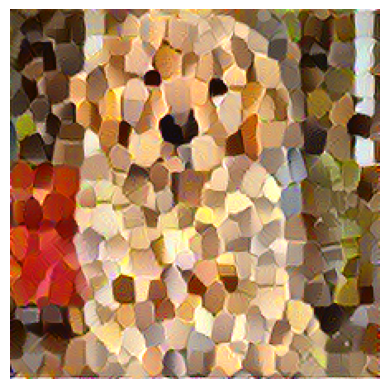

Image saved as generated_20250623_103432.jpg


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import vgg19
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

#Helper Functions
def preprocess_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return vgg19.preprocess_input(img)

def deprocess_image(x):
    x = x.reshape((224, 224, 3))
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]  # BGR to RGB
    x = np.clip(x, 0, 255).astype('uint8')
    return x

#Load Images
content_path = 'Dog.jpg'  # replace with your content image path
style_path = 'Screenshot 2025-06-23 152241.jpg'      # replace with your style image path

content_image = preprocess_image(content_path)
style_image = preprocess_image(style_path)

#Define Model
content_layer = 'block5_conv2'
style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1'
]

num_style_layers = len(style_layers)

def get_model():
    vgg = vgg19.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    content_output = vgg.get_layer(content_layer).output
    style_outputs = [vgg.get_layer(name).output for name in style_layers]
    model_outputs = style_outputs + [content_output]
    return tf.keras.Model(vgg.input, model_outputs)

#Style and Content Representation
def gram_matrix(tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', tensor, tensor)
    input_shape = tf.shape(tensor)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return result / num_locations

def get_features(model, content, style):
    content_outputs = model(content)
    style_outputs = model(style)
    style_features = [gram_matrix(output) for output in style_outputs[:num_style_layers]]
    content_features = content_outputs[num_style_layers:]
    return style_features, content_features

#Loss Functions
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
    style_weight, content_weight = loss_weights
    model_outputs = model(init_image)

    style_output_features = model_outputs[:num_style_layers]
    content_output_features = model_outputs[num_style_layers:]

    style_score = 0
    content_score = 0

    for target_style, comb_style in zip(gram_style_features, style_output_features):
        gram_comb_style = gram_matrix(comb_style)
        style_score += tf.reduce_mean((gram_comb_style - target_style) ** 2)

    for target_content, comb_content in zip(content_features, content_output_features):
        content_score += tf.reduce_mean((comb_content - target_content) ** 2)

    style_score *= style_weight
    content_score *= content_weight

    total_loss = style_score + content_score
    return total_loss, style_score, content_score

# --- Optimization ---
@tf.function()
def compute_grads(cfg):
    with tf.GradientTape() as tape:
        all_loss = compute_loss(**cfg)
    total_loss = all_loss[0]
    return tape.gradient(total_loss, cfg['init_image']), all_loss

#Training Loop
def run_style_transfer(content_path, style_path,
                       num_iterations=1000, content_weight=1e3, style_weight=1e-2):

    model = get_model()
    for layer in model.layers:
        layer.trainable = False

    content_image = preprocess_image(content_path)
    style_image = preprocess_image(style_path)

    gram_style_features, content_features = get_features(model, content_image, style_image)

    init_image = tf.Variable(content_image, dtype=tf.float32)
    optimizer = tf.optimizers.Adam(learning_rate=5.0)

    best_loss, best_img = float('inf'), None

    loss_weights = (style_weight, content_weight)
    cfg = {
        'model': model,
        'loss_weights': loss_weights,
        'init_image': init_image,
        'gram_style_features': gram_style_features,
        'content_features': content_features
    }

    for i in range(num_iterations):
        grads, all_loss = compute_grads(cfg)
        total_loss, style_score, content_score = all_loss
        optimizer.apply_gradients([(grads, init_image)])
        init_image.assign(tf.clip_by_value(init_image, -103.939, 255.0 - 103.939))

        if total_loss < best_loss:
            best_loss = total_loss
            best_img = deprocess_image(init_image.numpy())

        if i % 100 == 0:
            print(f"Iteration {i}: Total loss: {total_loss.numpy():.4f}")

    return best_img
# --- Run NST and Display ---
result = run_style_transfer(content_path, style_path)

# Show the generated image
plt.imshow(result)
plt.axis('off')
plt.show()

# Save the generated image
from datetime import datetime
output_path = f"generated_{datetime.now().strftime('%Y%m%d_%H%M%S')}.jpg"
plt.imsave(output_path, result)
print(f"Image saved as {output_path}")

